# Simulation of Nuclear Binding Energies

### This notebook aims to analyze some basic observables of atomic nuclei and reproduce the binding energies using a simple neural network

### @author: HuidobroMG

In [21]:
# Import the modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [22]:
# Physical constants
uma = 1.6605390666e-27 # kg
MeV = 1.0735441023e-3 # uma
m_p = 1.67262192e-27 # kg
m_n = 1.67492749e-27 # kg

m_p /= uma*MeV
m_n /= uma*MeV
print('m_p (MeV) =', m_p)
print('m_n (MeV) =', m_n)

m_p (MeV) = 938.2720861119849
m_n (MeV) = 939.5654160317417


### We extract the dataset from [NuDat](https://www.nndc.bnl.gov/nudat3/)

In [23]:
# Read the dataset
file_name = 'nndc_nudat_data_export.csv'
df = pd.read_csv(file_name)

df.head()

,z,n,name,betaMinus,betaMinusUncertainty,positronEmission,positronEmissionUncertainty,alpha,alphaUncertainty,bindingEnergy,bindingEnergyUncertainty
0,0,1,1n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1H,NaN,NaN,-1800.0,0.0004,NaN,NaN,0.0,0.0000
2,1,1,2H,NaN,NaN,NaN,NaN,NaN,NaN,1110.0,0.0002
3,1,2,3H,18.5,0.00006,NaN,NaN,NaN,NaN,2820.0,0.0003
4,1,3,4H,22100.0,100.00000,NaN,NaN,NaN,NaN,1720.0,25.0000


In [24]:
# Add the baryon number to the dataframe
df.insert(2, 'A', df['z'] + df['n'])

# Rename some columns
df = df.rename(columns = {'z':'Z', 'n':'N', 'betaMinus':'beta- (keV)', 'betaMinusUncertainty':'unc. beta- (keV)',
                          'positronEmission':'beta+ (keV)', 'positronEmissionUncertainty':'unc. beta+ (keV)',
                          'bindingEnergy':'BE/A (keV)', 'bindingEnergyUncertainty':'unc. BE/A (keV)'})

# Add a column with the mass of the nuclei
df['M (MeV)'] = m_p*df['Z'] + m_n*df['N'] - 1e-3*df['BE/A (keV)']*df['A']

df.head()

,Z,N,A,name,beta- (keV),unc. beta- (keV),beta+ (keV),unc. beta+ (keV),alpha,alphaUncertainty,BE/A (keV),unc. BE/A (keV),M (MeV)
0,0,1,1,1n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1,1H,NaN,NaN,-1800.0,0.0004,NaN,NaN,0.0,0.0000,938.272086
2,1,1,2,2H,NaN,NaN,NaN,NaN,NaN,NaN,1110.0,0.0002,1875.617502
3,1,2,3,3H,18.5,0.00006,NaN,NaN,NaN,NaN,2820.0,0.0003,2808.942918
4,1,3,4,4H,22100.0,100.00000,NaN,NaN,NaN,NaN,1720.0,25.0000,3750.088334


In [25]:
# Display the number of rows (# of nuclei)
N, N_features = df.shape
print('N_nuclei =', N)

N_nuclei = 4107


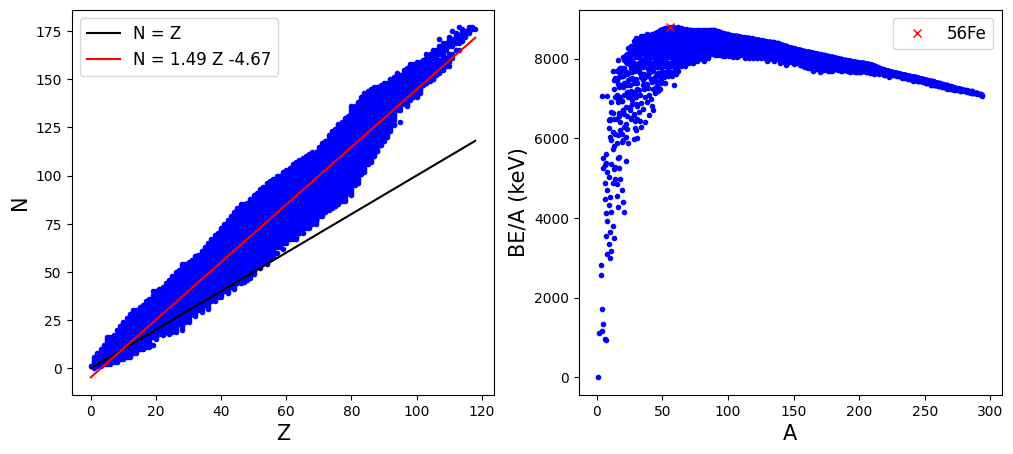

In [26]:
# Obtain a linear regression fit between N and Z
X = df['Z'].values.reshape(-1, 1)
y = df['N'].values 

model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_

# Find the most stable nuclei
idx_stable = df['BE/A (keV)'].idxmax()

# Plots
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(df['Z'], df['N'], 'b.')
ax1.plot(X, X, 'k-', label = 'N = Z')
ax1.plot(X, model.predict(X), 'r-', label = 'N = '+str(np.round(slope, 2))+' Z '+str(np.round(intercept, 2)))

ax2.plot(df['A'], df['BE/A (keV)'], 'b.')
ax2.plot(df['A'][idx_stable], df['BE/A (keV)'][idx_stable], 'rx', label = df['name'][idx_stable])

ax1.set_xlabel('Z', fontsize = 15)
ax1.set_ylabel('N', fontsize = 15)
ax2.set_xlabel('A', fontsize = 15)
ax2.set_ylabel('BE/A (keV)', fontsize = 15)

ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)

plt.show()

### There is actually a tension to determine the most stable nuclei between: 
$^{56}\text{Fe, } ^{58}\text{Fe and } ^{62}\text{Ni}$
### So we must check the uncertainties in their binding energies

In [27]:
# Check the other stable nuclei: 58Fe, 62Ni
idx_58Fe = np.where(df['name'] == '58Fe')[0][0]
idx_62Ni = np.where(df['name'] == '62Ni')[0][0]

df.iloc[[idx_stable, idx_58Fe, idx_62Ni]]

,Z,N,A,name,beta- (keV),unc. beta- (keV),beta+ (keV),unc. beta+ (keV),alpha,alphaUncertainty,BE/A (keV),unc. BE/A (keV),M (MeV)
534,26,30,56,56Fe,-4560.0,0.410,-4710.0,0.206,-7610.0,0.275,8790.0,0.00479,52089.796720
535,26,32,58,58Fe,-2300.0,1.130,-7340.0,2.710,-7640.0,0.321,8790.0,0.00550,53951.347552
616,28,34,62,62Ni,-3950.0,0.475,-6340.0,18.500,-7010.0,0.415,8790.0,0.00690,57671.862556


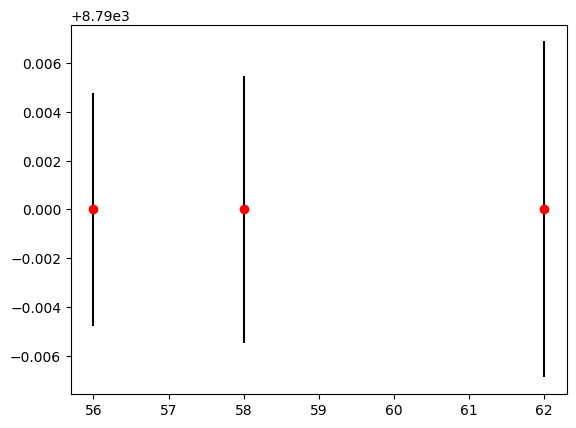

In [28]:
# Plot the values with errorbars
plt.errorbar(df.loc[idx_stable, 'A'], df.loc[idx_stable, 'BE/A (keV)'], yerr = df.loc[idx_stable, 'unc. BE/A (keV)'], marker = 'o', color = 'red', ecolor = 'black')
plt.errorbar(df.loc[idx_58Fe, 'A'], df.loc[idx_58Fe, 'BE/A (keV)'], yerr = df.loc[idx_58Fe, 'unc. BE/A (keV)'], marker = 'o', color = 'red', ecolor = 'black')
plt.errorbar(df.loc[idx_62Ni, 'A'], df.loc[idx_62Ni, 'BE/A (keV)'], yerr = df.loc[idx_62Ni, 'unc. BE/A (keV)'], marker = 'o', color = 'red', ecolor = 'black')

plt.show()

### Lets compare the experimental values of the masses with the [SEMF](https://en.wikipedia.org/wiki/Semi-empirical_mass_formula) results

In [29]:
# Parameters of the SEMF
aV = 15.8 # MeV
aS = 18.3 # MeV
aC = 0.714 # MeV
aA = 23.2 # MeV

# Values of the binding energies computed from the SEMF
BE = 1e3*(aV*df['A'] - aS*df['A']**(2/3) - aC*df['Z']*(df['Z']-1)/df['A']**(1/3) - aA*(df['N']-df['Z'])**2/df['A'])/df['A']

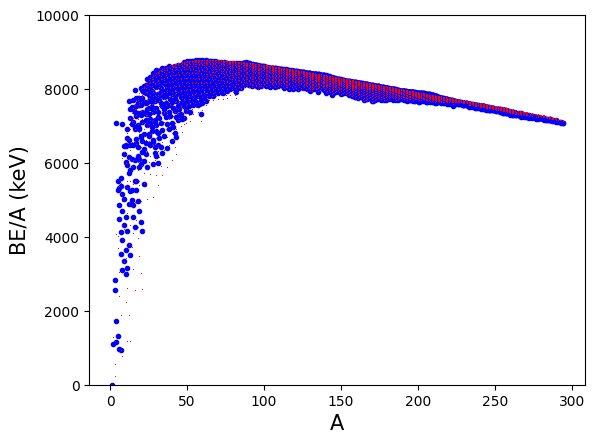

In [30]:
plt.plot(df['A'], df['BE/A (keV)'], 'b.')
plt.plot(df['A'], BE, 'r,')

plt.xlabel('A', fontsize = 15)
plt.ylabel('BE/A (keV)', fontsize = 15)

plt.ylim(0, 1e4)

plt.show()

### We will now construct a simple neural network to reproduce the data

In [31]:
# Define the features and the target
X = df[['Z', 'N', 'A']]
y = df['BE/A (keV)']

# Erase the nan values
idx = np.where(y.isnull())[0]
X = X.drop(X.index[idx])
y = y.drop(y.index[idx])

# Extract the values
X = X.values
y = y.values

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state = 42)

In [32]:
# Clear any built model
tf.keras.backend.clear_session()

In [33]:
# Create a simple NN to reproduce the data
model = Sequential()

# Input layer (3 neurons) plus hidden layers
model.add(Dense(32, input_dim = 3, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

# Output layer with 1 neuron
model.add(Dense(1))

# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Display a summary of the model
model.summary()

C:\Users\huido\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,881 (73.75 KB)

 Trainable params: 18,881 (73.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1780 - val_loss: 0.0038
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5038e-04 - val_loss: 0.0016
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3688e-04 - val_loss: 0.0013
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6234e-04 - val_loss: 0.0014
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━

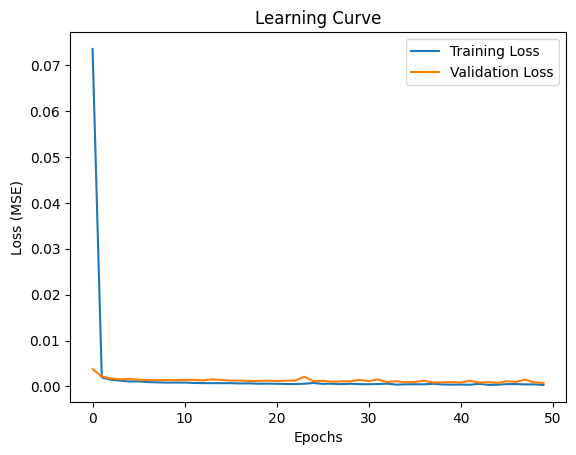

In [35]:
# Plot the learning curve
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.title('Learning Curve')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()

plt.show()

In [36]:
# Make prediction
prediction = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [37]:
# Recover the former scales
X_test_original = scaler_X.inverse_transform(X_test)
y_test_original = scaler_y.inverse_transform(y_test)
prediction_original = scaler_y.inverse_transform(prediction)

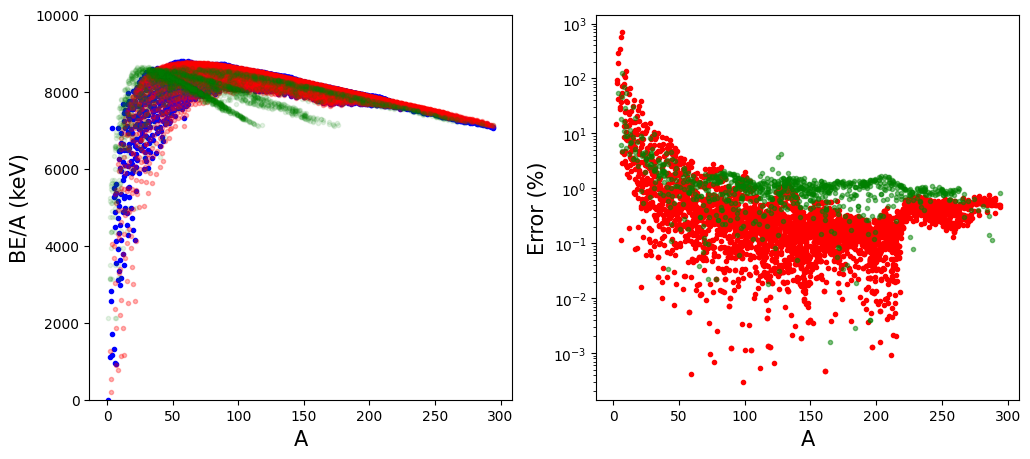

In [39]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(df['A'], df['BE/A (keV)'], 'b.')
ax1.plot(df['A'], BE, 'r.', alpha = 0.3)
ax1.plot(X_test_original, prediction_original, 'g.', alpha = 0.1)

ax2.plot(df['A'], 100*abs(df['BE/A (keV)'] - BE)/df['BE/A (keV)'], 'r.')
ax2.plot(X_test_original[:, 2], 100*abs(y_test_original - prediction_original)/y_test_original, 'g.', alpha = 0.5)

ax1.set_xlabel('A', fontsize = 15)
ax1.set_ylabel('BE/A (keV)', fontsize = 15)
ax2.set_xlabel('A', fontsize = 15)
ax2.set_ylabel('Error (%)', fontsize = 15)

ax1.set_ylim(0, 1e4)
ax2.set_yscale('log')

plt.show()